In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#list of useful imports that  I will use
%matplotlib inline
import os

import matplotlib.pyplot as plt
import pandas as pd

import numpy as np

import seaborn as sns
import random
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# Imputer
#from sklearn.preprocessing import Imputer

from sklearn.impute import SimpleImputer
#imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
from sklearn_pandas import DataFrameMapper
# from feature_engine.imputation import CategoricalImputer

In [2]:
# prompt: mount code

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
data = pd.read_csv('/content/drive/MyDrive/12.SPAMVSHAM_SMS.csv')

In [4]:
data

,v1,v2
0,spam,U were outbid by simonwatson5120 on the Shinco...
1,ham,Do you still have the grinder?
2,ham,No. Yes please. Been swimming?
3,ham,No de.am seeing in online shop so that i asked.
4,ham,"Faith makes things possible,Hope makes things ..."
...,...,...
4452,ham,Good. Good job. I like entrepreneurs
4453,ham,Living is very simple.. Loving is also simple....
4454,ham,Msgs r not time pass.They silently say that I ...
4455,ham,What is this 'hex' place you talk of? Explain!


In [5]:
data.shape

(4457, 2)

In [6]:
#Check the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4457 entries, 0 to 4456
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      4457 non-null   object
 1   v2      4457 non-null   object
dtypes: object(2)
memory usage: 69.8+ KB


In [7]:
data['v1'].value_counts()

ham     3868
spam     589
Name: v1, dtype: int64

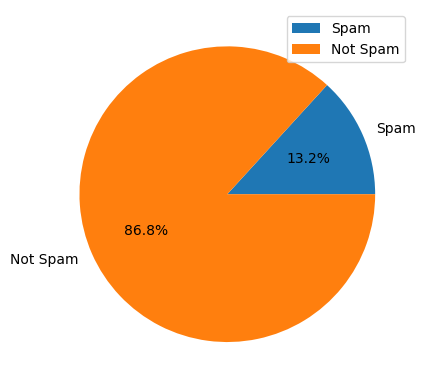

In [8]:
ns = data['v1'].isin(['ham']).sum(axis=0)
s = data['v1'].isin(['spam']).sum(axis=0)

label=['Spam','Not Spam']
a = [s,ns]
plt.pie(x=a,labels=label,autopct='%1.1f%%')
plt.legend()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

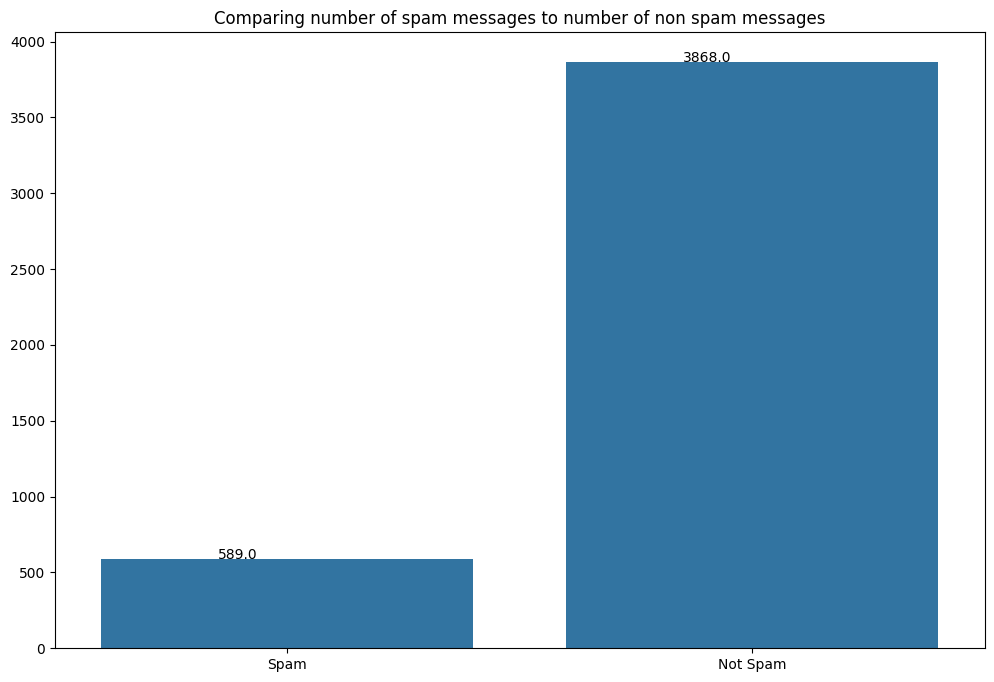

In [9]:
plt.figure(figsize=(12,8))
ax =sns.barplot(x=label,y=a)
plt.title('Comparing number of spam messages to number of non spam messages')
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.annotate('{}'.format(height), (x +0.25, y + height + 0.8))
plt.show

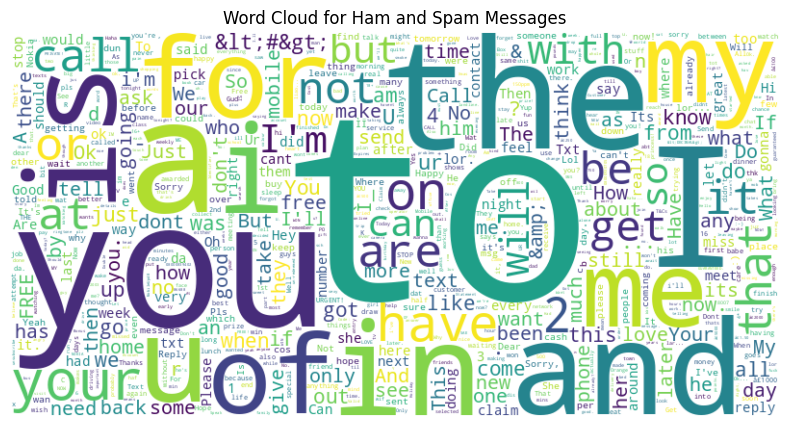

In [10]:
from collections import Counter
from wordcloud import WordCloud

# Tokenize the text into words
words = ' '.join(data['v2']).split()

# Count word frequencies
word_freq = Counter(words)

# Word cloud visualization
wordcloud = WordCloud(width=800, height=400, max_words=2500, background_color='white').generate_from_frequencies(word_freq)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Ham and Spam Messages')
plt.show()


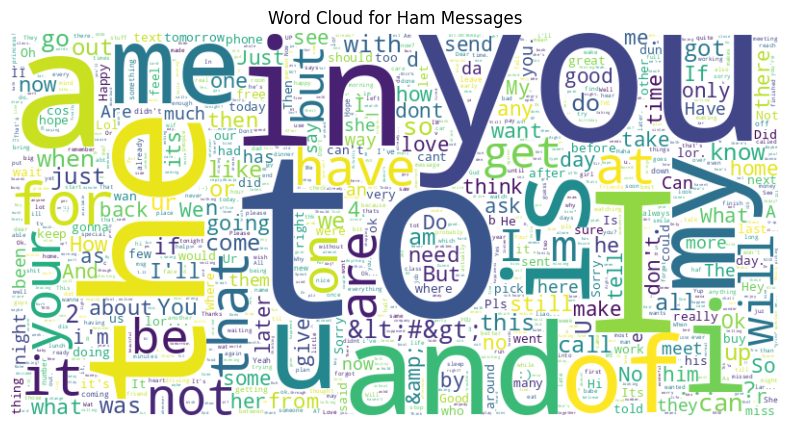

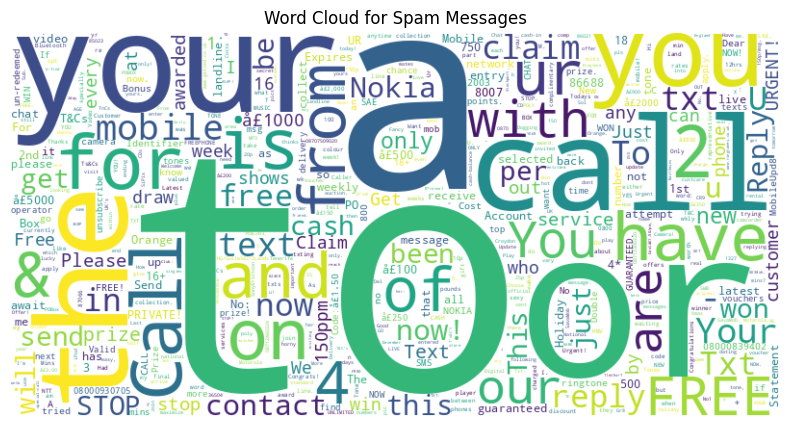

In [11]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter words for 'ham' class
ham_words = ' '.join(data[data['v1'] == 'ham']['v2']).split()
ham_word_freq = Counter(ham_words)

# Generate word cloud for 'ham' class
ham_wordcloud = WordCloud(width=800, height=400, max_words=2500, background_color='white').generate_from_frequencies(ham_word_freq)
plt.figure(figsize=(10, 5))
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Ham Messages')
plt.show()

# Filter words for 'spam' class
spam_words = ' '.join(data[data['v1'] == 'spam']['v2']).split()
spam_word_freq = Counter(spam_words)

# Generate word cloud for 'spam' class
spam_wordcloud = WordCloud(width=800, height=400, max_words=2500, background_color='white').generate_from_frequencies(spam_word_freq)
plt.figure(figsize=(10, 5))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Spam Messages')
plt.show()

In [12]:
from sklearn.utils import resample
# Separate majority and minority classes
df_majority = data[data['v1']== 'ham']
df_minority = data[data['v1']== 'spam']

# Downsample majority class and upsample the minority class
df_minority_upsampled = resample(df_minority, replace=True,n_samples=3500,random_state=123)
df_majority_downsampled = resample(df_majority, replace=True,n_samples=3500,random_state=123)

# Combine minority class with downsampled majority class
df_upsampled = pd.concat([df_minority_upsampled, df_majority_downsampled])

# Display new class counts
df_upsampled['v1'].value_counts()

spam    3500
ham     3500
Name: v1, dtype: int64

In [13]:
# shuffle the DataFrame rows
data= df_upsampled.sample(frac = 1)

In [14]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [15]:
# remove punctuation
import re
import string

def remove_punc(text):
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

data['v2'] = data['v2'].apply(lambda x: remove_punc(x))

In [16]:
import nltk
from nltk.corpus import stopwords
# Download NLTK data (if not already downloaded)
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [17]:
from nltk.stem import PorterStemmer, WordNetLemmatizer
def data_cleaner(text, use_stemming=True, use_lemmatization=True):
    # Convert to lowercase
    lower_case = text.lower()

    # Tokenize the text
    tokens = word_tokenize(lower_case)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Stemming
    if use_stemming:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(token) for token in tokens]

    # Lemmatization
    if use_lemmatization:
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return " ".join(tokens).strip()


In [18]:
from sklearn.preprocessing import LabelEncoder

In [19]:
le = LabelEncoder()
y = le.fit_transform(data['v1'])
y = np.array(y)

In [20]:
# Print the class names associated with label encoding
class_names = le.classes_
print("Class Names:", class_names)

Class Names: ['ham' 'spam']


In [21]:
x=data['v2']

In [22]:
from sklearn.model_selection import train_test_split
#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3,stratify=y ,random_state=42)

In [23]:
X_train.shape,y_train.shape

((4900,), (4900,))

In [24]:
 X_test.shape,y_test.shape

((2100,), (2100,))

In [25]:
!pip3 install --quiet tensorflow_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 16.2 MB/s eta 0:00:00


In [26]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTEN
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
#from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from wordcloud import WordCloud

In [35]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [36]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model1 = tf.keras.Model(inputs=[text_input], outputs = [l])

In [37]:
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer_2 (KerasLayer)  {'input_mask': (None, 128)   0         ['text[0][0]']                
                             , 'input_type_ids': (None,                                           
                              128),                                                               
                              'input_word_ids': (None,                                            
                             128)}                                                                
                                                                                            

In [38]:

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [ ]:
model1.fit(X_train, y_train, epochs=1)

  2/154 [..............................] - ETA: 49:24 - loss: 0.9471 - accuracy: 0.6094 - precision: 0.0000e+00 - recall: 0.0000e+00  

In [ ]:
score=model1.evaluate(X_test, y_test)

In [ ]:
print('Test accuracy:', score[1])

In [ ]:
y_predicted = model1.predict(X_test)
y_predicted = y_predicted.flatten()

In [ ]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

In [ ]:
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
print(classification_report(y_test, y_predicted))